In [ ]:
def smart_rename(input_dict):
    aliases = {
        # ✅ توحيد العمر
        'Age_of_the_patient': 'Age',
        'age': 'Age',

        # ✅ توحيد الجنس
        'sex': 'Gender',
        'Sex': 'Gender',
        'Gender_of_the_patient': 'Gender',

        # ✅ توحيد الضغط
        'bp': 'BloodPressure',
        'Blood_Pressure': 'BloodPressure',

        # ✅ توحيد الجلوكوز
        'bgr': 'Glucose',

        # ✅ توحيد country
        'country': 'Country',

        # ✅ kidney disease اختصارات
        'sg': 'SpecificGravity',
        'al': 'AlbuminLevel',
        'su': 'SugarLevel',
        'rbc': 'RedBloodCellCount',
        'pc': 'PusCell',
        'pcc': 'PusCellClumps',
        'ba': 'Bacteria',
        'bgr': 'BloodGlucoseRandom',
        'bu': 'BloodUrea',
        'sc': 'SerumCreatinine',
        'sod': 'Sodium',
        'pot': 'Potassium',
        'hemo': 'Hemoglobin',
        'pcv': 'PackedCellVolume',
        'wc': 'WhiteBloodCellCount',
        'rc': 'RedBloodCellCount',
        'htn': 'Hypertension',
        'dm': 'DiabetesMellitus',
        'cad': 'CoronaryArteryDisease',
        'appet': 'Appetite',
        'pe': 'PedalEdema',
        'ane': 'Anemia',



        # ✅ thyroid
        'on thyroxine': 'on_thyroxine',
        'on antithyroid medication': 'on_antithyroid_medication',
        'query on thyroxine': 'query_on_thyroxine',
        'I131 treatment': 'I131_treatment',
        'thyroid surgery': 'thyroid_surgery',
        'query hypothyroid': 'query_hypothyroid',
        'query hyperthyroid': 'query_hyperthyroid',
    }

    new_dict = {}
    for k, v in input_dict.items():
        new_key = aliases.get(k.strip(), k.strip())
        new_dict[new_key] = v
    return new_dict


In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

# ترميز ثابت لبعض الحقول المهمة (نفس الترتيب اللي اتدرب عليه الموديل)
country_encoder = LabelEncoder()
country_encoder.classes_ = np.array(["Egypt", "France", "Germany", "India", "UK", "USA"])

activity_map = {'low': 0, 'medium': 1, 'high': 2}
stress_map = {'low': 0, 'medium': 1, 'high': 2}
salt_map = {'low': 0, 'medium': 1, 'high': 2}
education_map = {'low': 0, 'medium': 1, 'high': 2}
employment_map = {'unemployed': 0, 'employed': 1}

binary_map = {
    "yes": 1, "no": 0,
    "male": 1, "female": 0,
    "Male": 1, "Female": 0,
    "normal": 1, "abnormal": 0,
    "present": 1, "notpresent": 0,
    "good": 1, "poor": 0,
    "True": 1, "False": 0
}

def preprocess_input(input_dict):
    output = {}

    for k, v in input_dict.items():
        if v is None or (isinstance(v, float) and np.isnan(v)):
            output[k] = 0
            continue

        v_str = str(v).strip().lower()

        # ترميز مخصص للأعمدة المعروفة
        if k == "Country":
            try:
                output[k] = int(country_encoder.transform([v])[0])
            except:
                output[k] = 0  # لو مش من ضمن الدول

        elif k == "Physical_Activity_Level":
            output[k] = activity_map.get(v_str, 0)

        elif k == "Stress_Level":
            output[k] = stress_map.get(v_str, 0)

        elif k == "Salt_Intake":
            output[k] = salt_map.get(v_str, 0)

        elif k == "Education_Level":
            output[k] = education_map.get(v_str, 0)

        elif k == "Employment_Status":
            output[k] = employment_map.get(v_str, 0)

        elif v_str in binary_map:
            output[k] = binary_map[v_str]

        else:
            try:
                output[k] = float(v)  # أرقام مباشرة
            except:
                output[k] = 0  # fallback لأي حاجة مش مفهومة

    return output


In [ ]:
import pandas as pd
import numpy as np

def unified_predict(user_input):
    results = {}

    # تفسير درجات أمراض القلب
    heart_classes = {
        0: "🟢 سليم",
        1: "🟡 درجة أولى",
        2: "🟠 درجة تانية",
        3: "🔴 درجة تالتة",
        4: "🚨 حالة حرجة"
    }

    for disease, model_info in models.items():
        model = model_info["model"]
        required_features = model_info["features"]

        # ملء القيم الناقصة بصفر
        input_filled = {
            f: user_input.get(f, 0)
            for f in required_features
        }

        input_df = pd.DataFrame([input_filled])[required_features]

        try:
            # التنبؤ
            if hasattr(model, "predict_proba"):
                probas = model.predict_proba(input_df)
                pred = int(np.argmax(probas[0]))
                prob_percent = f"{probas[0][pred] * 100:.2f}%"
            else:
                pred_array = model.predict(input_df)
                pred = int(pred_array[0])
                prob_percent = "N/A"

            # النتيجة النهائية حسب نوع التصنيف
            unique_classes = getattr(model, "classes_", [0, 1])
            is_binary = len(unique_classes) == 2

            if is_binary:
                if pred == 1:
                    result_str = f"✅ Positive ({prob_percent})"
                else:
                    if prob_percent != "N/A":
                        neg_percent = f"{100 - float(prob_percent.strip('%')):.2f}%"
                    else:
                        neg_percent = "N/A"
                    result_str = f"🟢 Negative ({neg_percent})"
            else:  # multi-class مثل القلب
                if disease == "Heart Disease" and pred in heart_classes:
                    result_str = f"{heart_classes[pred]} ({prob_percent})"
                else:
                    result_str = f"🔷 Class {pred} ({prob_percent})"

            # تنبيه لو فيه بيانات ناقصة
            missing = [f for f in required_features if f not in user_input]
            if missing:
                result_str += f" ⚠️ Missing features: {missing}"

            results[disease] = result_str

        except Exception as e:
            results[disease] = f"❌ Prediction error: {str(e)}"

    return results


In [ ]:

# ✅ دالة لتحويل yes/no وغيرها لقيم رقمية
def preprocess_input(input_dict):
    mapping = {
        "yes": 1, "no": 0,
        "male": 1, "female": 0,
        "Male": 1, "Female": 0,
        "normal": 1, "abnormal": 0,
        "present": 1, "notpresent": 0,
        "good": 1, "poor": 0,
        "yes": 1, "no": 0,
        "True": 1, "False": 0
    }
    return {k: mapping.get(str(v), v) for k, v in input_dict.items()}


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:07:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 70.13%
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        99
           1       0.57      0.64      0.60        55

    accuracy                           0.70       154
   macro avg       0.68      0.69      0.68       154
weighted avg       0.71      0.70      0.70       154



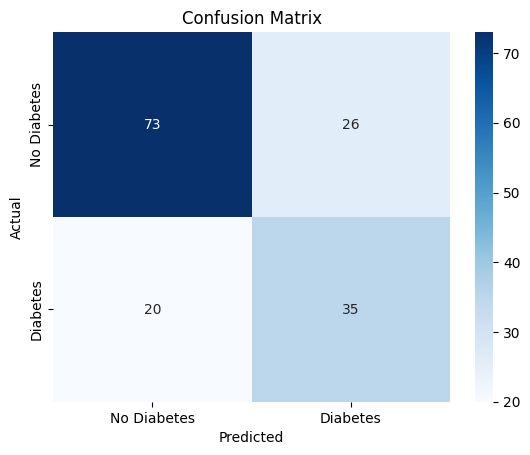

💾 تم حفظ موديل XGBoost بنجاح!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from xgboost import XGBClassifier

# تحميل البيانات
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv("diabetes.csv", header=0, names=column_names)

# تعويض القيم المفقودة
cols_to_replace = ['Insulin', 'BloodPressure', 'SkinThickness', 'BMI']
for col in cols_to_replace:
    df[col] = df[col].replace(0, np.nan)
    df[col] = df[col].fillna(df[col].mean())

# فصل الخصائص والنتيجة
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تدريب موديل XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# التنبؤ
y_pred = model.predict(X_test)

# التقييم
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy * 100:.2f}%")

print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# مصفوفة الالتباس
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# حفظ الموديل
joblib.dump(model, 'xgb_diabetes_model.pkl')
print("💾 تم حفظ موديل XGBoost بنجاح!")


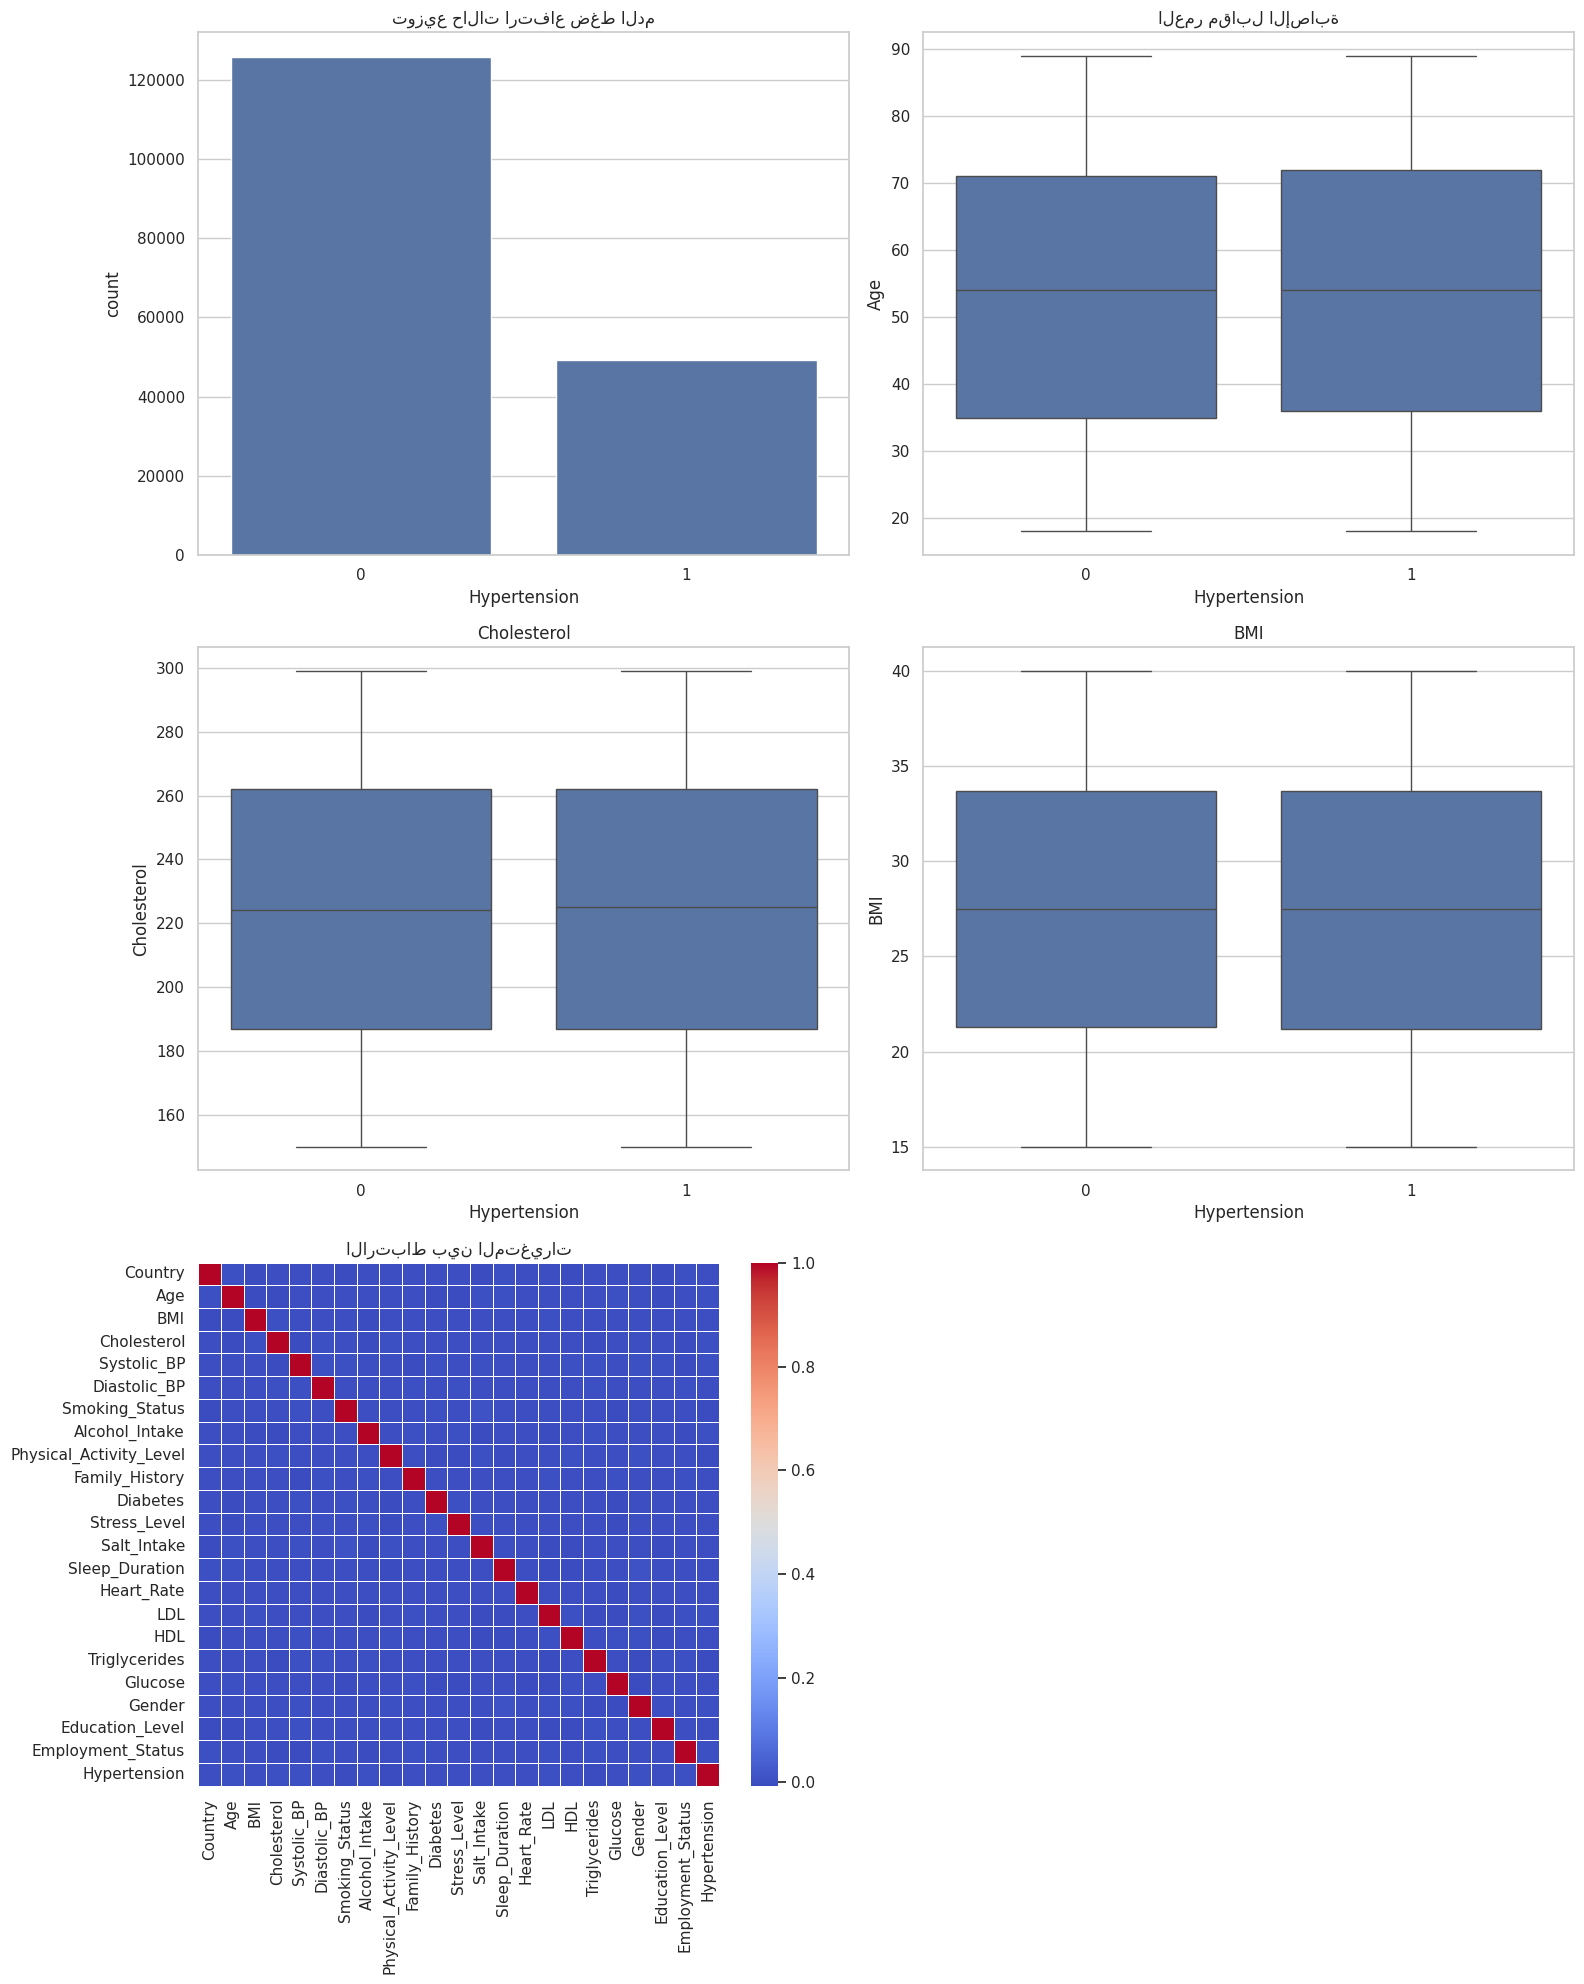

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:37:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ دقة موديل XGBoost: 71.34%
📋 Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.99      0.83     25108
           1       0.28      0.01      0.02      9889

    accuracy                           0.71     34997
   macro avg       0.50      0.50      0.43     34997
weighted avg       0.59      0.71      0.60     34997

💾 ✔️ تم حفظ موديل الضغط بنجاح!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib
from xgboost import XGBClassifier

# تحميل البيانات
df = pd.read_csv("hypertension.csv")
df.dropna(inplace=True)

# ترميز الأعمدة النصية
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# تحليل بصري
sns.set(style="whitegrid")
plt.figure(figsize=(16, 20))

plt.subplot(3, 2, 1)
sns.countplot(x='Hypertension', data=df)
plt.title("توزيع حالات ارتفاع ضغط الدم")

plt.subplot(3, 2, 2)
sns.boxplot(x='Hypertension', y='Age', data=df)
plt.title("العمر مقابل الإصابة")

if 'Cholesterol' in df.columns:
    plt.subplot(3, 2, 3)
    sns.boxplot(x='Hypertension', y='Cholesterol', data=df)
    plt.title("Cholesterol")

if 'BMI' in df.columns:
    plt.subplot(3, 2, 4)
    sns.boxplot(x='Hypertension', y='BMI', data=df)
    plt.title("BMI")

plt.subplot(3, 2, 5)
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', linewidths=0.5)
plt.title("الارتباط بين المتغيرات")

if 'SystolicBP' in df.columns and 'DiastolicBP' in df.columns:
    plt.subplot(3, 2, 6)
    sns.scatterplot(x='SystolicBP', y='DiastolicBP', hue='Hypertension', data=df)
    plt.title("Systolic vs Diastolic BP")

plt.tight_layout()
plt.show()

# تدريب موديل XGBoost
X = df.drop(columns=['Hypertension'])
y = df['Hypertension']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# التقييم
y_pred = model.predict(X_test)
print(f"✅ دقة موديل XGBoost: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("📋 Classification Report:")
print(classification_report(y_test, y_pred))

# حفظ الموديل
joblib.dump(model, "xgb_hypertension_model.pkl")
print("💾 ✔️ تم حفظ موديل الضغط بنجاح!")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib

# تحميل البيانات
df = pd.read_csv("kidney.csv")
df.dropna(inplace=True)

# ترميز الأعمدة النصية
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# فصل البيانات
target_col = 'classification'
X = df.drop(columns=[target_col])
y = df[target_col]

# تقسيم البيانات قبل التوازن
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# تطبيق SMOTE لتوازن الكلاسات في بيانات التدريب
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("✅ ✅ بعد SMOTE:")
print(y_train_balanced.value_counts())

# تدريب موديل XGBoost بعد التوازن
model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=4,
    learning_rate=0.07,
    n_estimators=250,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(
    X_train_balanced,
    y_train_balanced,
    eval_set=[(X_test, y_test)],

)

# التقييم
y_pred = model.predict(X_test)
print(f"\n✅ Model Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# حفظ الموديل
joblib.dump(model, "xgb_ckd_model_smote.pkl")
print("\n💾 ✅ تم حفظ موديل أمراض الكلى بعد تطبيق SMOTE بنجاح!")


✅ ✅ بعد SMOTE:
classification
1    92
0    92
Name: count, dtype: int64
[0]	validation_0-logloss:0.63308


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:38:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1]	validation_0-logloss:0.58087
[2]	validation_0-logloss:0.53506
[3]	validation_0-logloss:0.49446
[4]	validation_0-logloss:0.45837
[5]	validation_0-logloss:0.42615
[6]	validation_0-logloss:0.39745
[7]	validation_0-logloss:0.37169
[8]	validation_0-logloss:0.34849
[9]	validation_0-logloss:0.32754
[10]	validation_0-logloss:0.30859
[11]	validation_0-logloss:0.29157
[12]	validation_0-logloss:0.27845
[13]	validation_0-logloss:0.26428
[14]	validation_0-logloss:0.25144
[15]	validation_0-logloss:0.23979
[16]	validation_0-logloss:0.22927
[17]	validation_0-logloss:0.21967
[18]	validation_0-logloss:0.20789
[19]	validation_0-logloss:0.19990
[20]	validation_0-logloss:0.19262
[21]	validation_0-logloss:0.18606
[22]	validation_0-logloss:0.17747
[23]	validation_0-logloss:0.17195
[24]	validation_0-logloss:0.16697
[25]	validation_0-logloss:0.16247
[26]	validation_0-logloss:0.15843
[27]	validation_0-logloss:0.15485
[28]	validation_0-logloss:0.15157
[29]	validation_0-logloss:0.14547
[30]	validation_0-loglo

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# تحميل البيانات
df = pd.read_csv("Liver.csv", encoding="ISO-8859-1")

# تنظيف أسماء الأعمدة
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace(r"[^a-zA-Z0-9_]", "", regex=True)

# حذف الصفوف التي تحتوي على قيم مفقودة
df.dropna(inplace=True)

# ترميز الأعمدة النصية
for col in df.select_dtypes(include="object").columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# معاينة التوزيع
sns.countplot(x="Result", data=df)
plt.title("Distribution of Result")
plt.show()

# فصل السمات عن الهدف
X = df.drop(columns=["Result"])
y = df["Result"]

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# تدريب الموديل
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# التقييم
y_pred = model.predict(X_test)
print("\n✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# حفظ الموديل
joblib.dump(model, "liver_model.pkl")
print("\n💾 Model saved as liver_model.pkl")



✅ Accuracy: 91.61%

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94      3896
           1       0.77      1.00      0.87      1536

    accuracy                           0.92      5432
   macro avg       0.89      0.94      0.90      5432
weighted avg       0.94      0.92      0.92      5432

💾 تم حفظ موديل الكبد باسم rf_liver_model.pkl


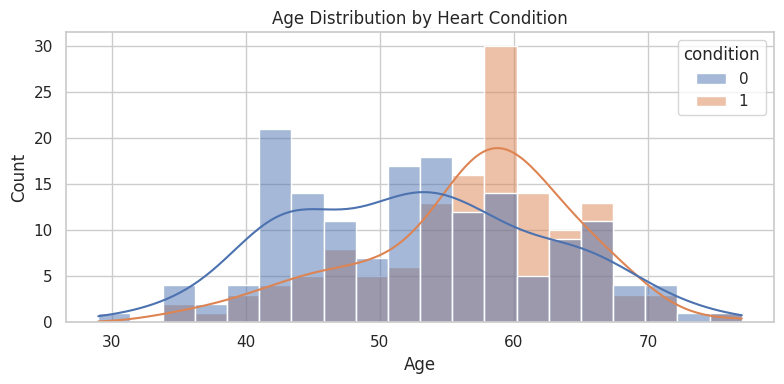

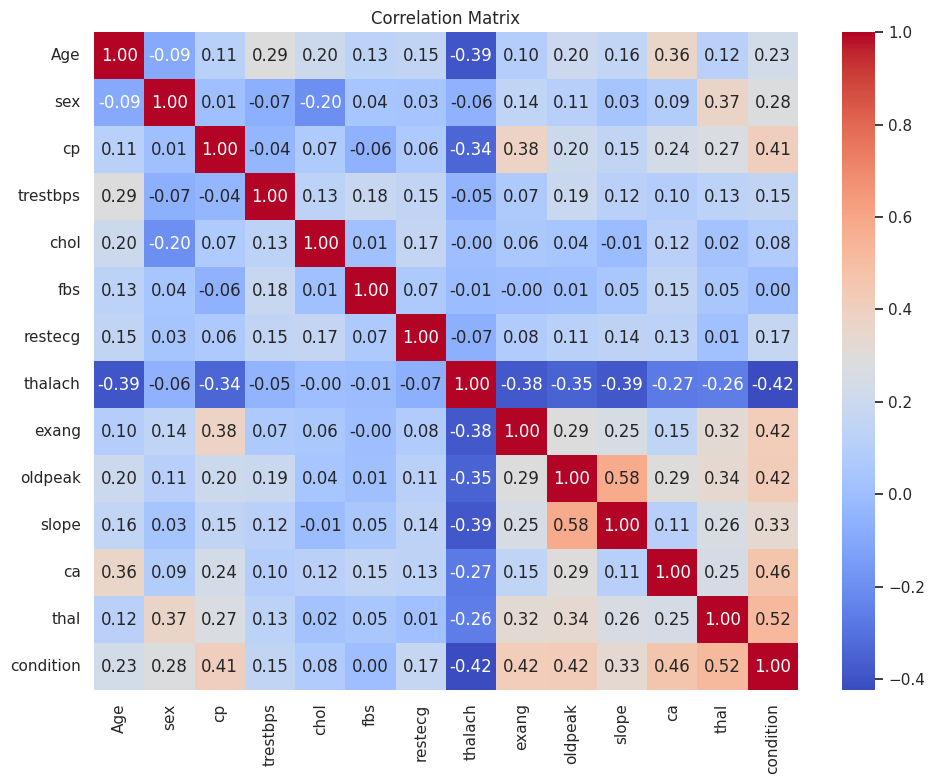

✅ Accuracy: 0.6833333333333333
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.66      0.68      0.67        28

    accuracy                           0.68        60
   macro avg       0.68      0.68      0.68        60
weighted avg       0.68      0.68      0.68        60

🧮 Confusion Matrix:
 [[22 10]
 [ 9 19]]
💾 تم حفظ موديل القلب بنجاح!


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:38:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import pandas as pd
import numpy as np # Import numpy for argmax
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
from xgboost import XGBClassifier

# قراءة البيانات
df = pd.read_csv("heart.csv")

# تنظيف البيانات
df = df.drop_duplicates()
df = df[df['chol'] < 600]  # إزالة القيم الغريبة

# رسم بياني للعمر
plt.figure(figsize=(8, 4))
sns.histplot(data=df, x='Age', hue='condition', kde=True, bins=20)
plt.title("Age Distribution by Heart Condition")
plt.tight_layout()
plt.show()

# خريطة الارتباط
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# فصل البيانات
X = df.drop("condition", axis=1)
y = df["condition"]

# توحيد القيم
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# عدد الكلاسات
num_classes = len(y.unique())

# تدريب موديل XGBoost
model = XGBClassifier(
    objective='multi:softprob',
    num_class=num_classes,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train_scaled, y_train)

# التنبؤ
y_pred = model.predict(X_test_scaled)

# Ensure y_pred is 1-dimensional before creating a Series
# If predict returns probabilities (2D), get the class with the highest probability
if y_pred.ndim > 1:
  y_pred = np.argmax(y_pred, axis=1)

# تأكد إن كل القيم أرقام صحيحة
y_test = pd.Series(y_test).astype(int)
y_pred = pd.Series(y_pred).astype(int)

# التقييم
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("📋 Classification Report:\n", classification_report(y_test, y_pred))
print("🧮 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# حفظ الموديل
joblib.dump(model, "heart_model.pkl")
print("💾 تم حفظ موديل القلب بنجاح!")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:38:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 95.61%
📋 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97        71
           1       0.95      0.93      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

🧮 Confusion Matrix:
 [[69  2]
 [ 3 40]]


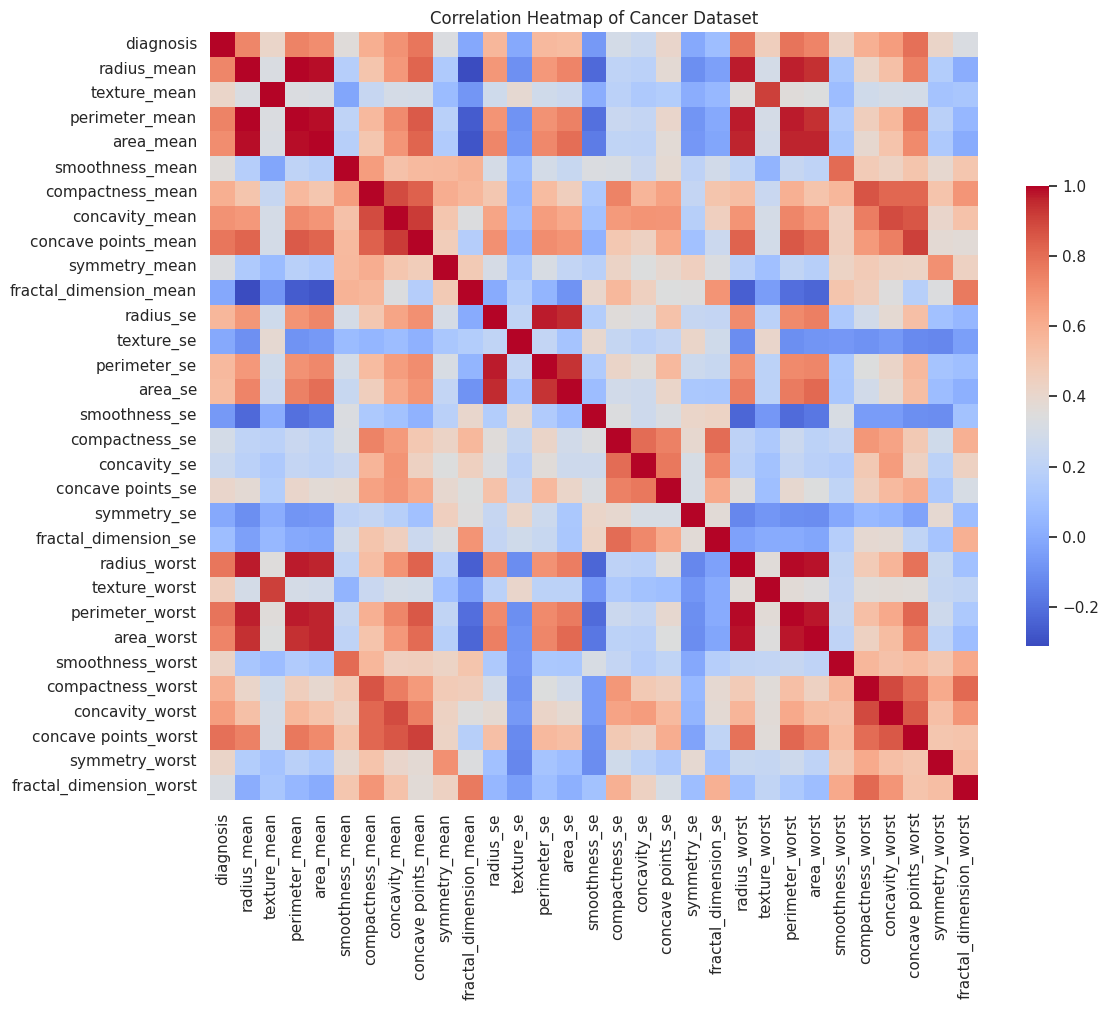

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
from xgboost import XGBClassifier

# تحميل البيانات
df = pd.read_csv("cancer.csv")

# تنظيف الأعمدة غير الضرورية
if 'id' in df.columns:
    df.drop(['id'], axis=1, inplace=True)
if 'Unnamed: 32' in df.columns:
    df.drop(['Unnamed: 32'], axis=1, inplace=True)

# تحويل القيم النصية إلى رقمية
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# خريطة الارتباط
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), cmap='coolwarm', square=True, cbar_kws={'shrink': .6})
plt.title("Correlation Heatmap of Cancer Dataset")
plt.tight_layout()
plt.savefig("cancer_correlation_heatmap.png")

# فصل البيانات
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# توحيد القيم Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# تدريب موديل XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# التقييم
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# حفظ الموديل والسكالر
joblib.dump(model, "xgb_cancer_model.pkl")

# النتائج
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
print("📋 Classification Report:\n", report)
print("🧮 Confusion Matrix:\n", conf_matrix)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:39:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Accuracy: 99.47%
📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       697
           1       0.98      0.95      0.96        58

    accuracy                           0.99       755
   macro avg       0.99      0.97      0.98       755
weighted avg       0.99      0.99      0.99       755

🧮 Confusion Matrix:
 [[696   1]
 [  3  55]]


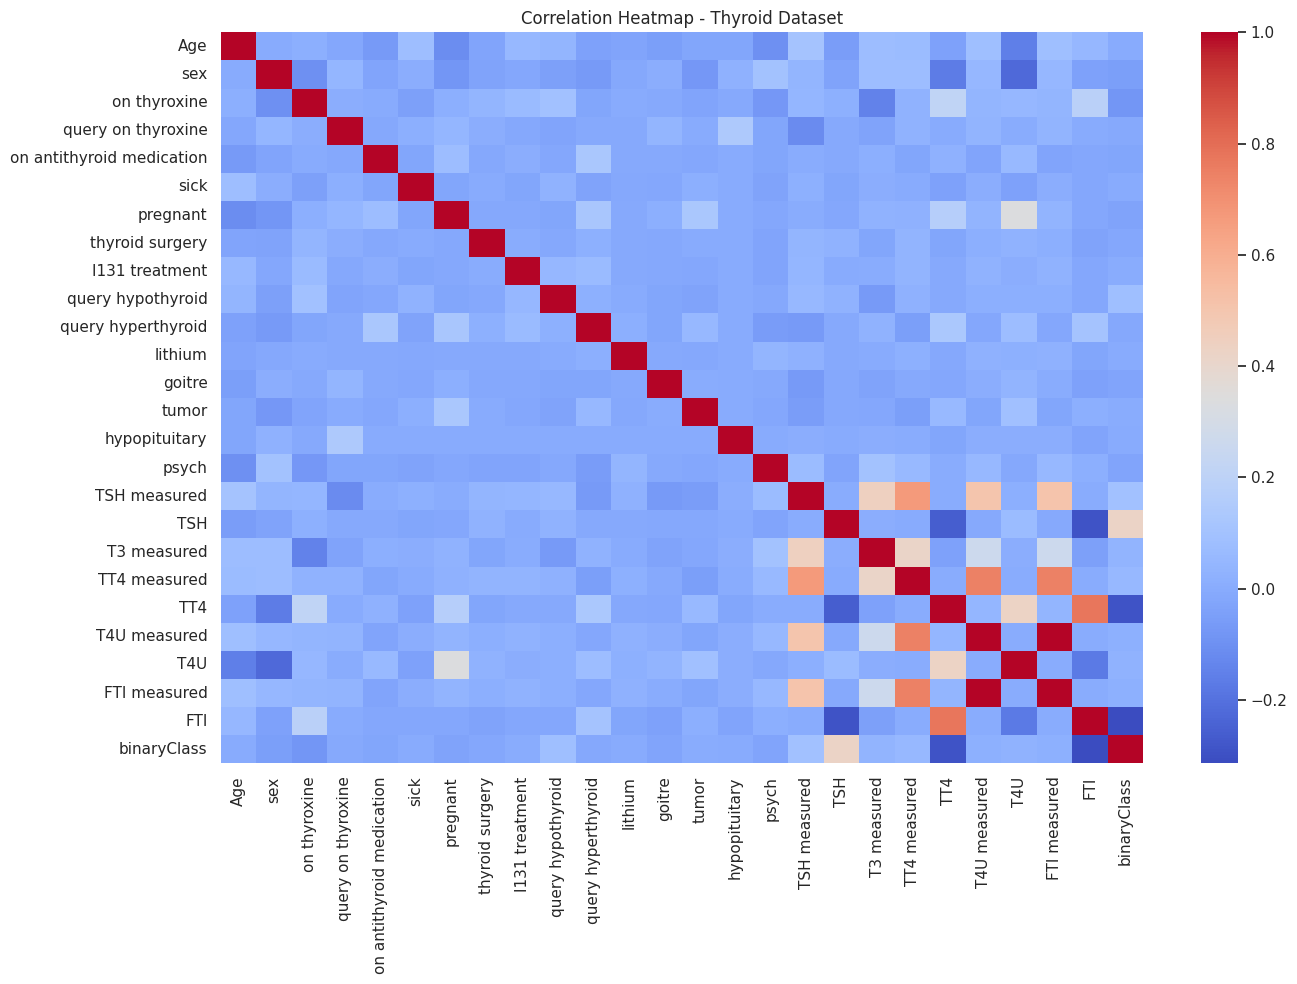

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
from xgboost import XGBClassifier

# تحميل البيانات
df = pd.read_csv("Thyroid.csv")

# خريطة الارتباط
plt.figure(figsize=(14, 10))
corr = df.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", fmt='.2f')
plt.title("Correlation Heatmap - Thyroid Dataset")
plt.tight_layout()
plt.savefig("thyroid_correlation_heatmap.png")

# فصل البيانات
X = df.drop("binaryClass", axis=1)
y = df["binaryClass"]

# توحيد البيانات
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# تدريب موديل XGBoost
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# التقييم
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# حفظ الموديل والسكالر
joblib.dump(model, "xgb_thyroid_model.pkl")
joblib.dump(scaler, "xgb_thyroid_scaler.pkl")

# طباعة النتائج
print(f"✅ Accuracy: {accuracy * 100:.2f}%")
print("📋 Classification Report:\n", report)
print("🧮 Confusion Matrix:\n", conf_matrix)


In [ ]:
import joblib

models = {
    "diabetes": joblib.load("xgb_diabetes_model.pkl"),
    "hypertension": joblib.load("xgb_hypertension_model.pkl"),
    "kidney": joblib.load("/content/xgb_ckd_model_smote.pkl"),
    "liver": joblib.load("/content/rf_liver_model.pkl"),
    "heart": joblib.load("/content/heart_model.pkl"),
    "thyroid": joblib.load("xgb_thyroid_model.pkl"),
    "cancer": joblib.load("xgb_cancer_model.pkl"),
}


In [ ]:
def predict_disease(user_input, disease_name):
    input_data = smart_rename(user_input)

    model = models[disease_name]
    required_features = set(model.feature_names_in_)

    # 🔥 هنا الفلترة: بنشيل أي feature مش مطلوب
    filtered_data = {k: v for k, v in input_data.items() if k in required_features}

    # نجهز الداتا للتنبؤ
    input_df = pd.DataFrame([filtered_data])
    input_df = input_df.reindex(columns=model.feature_names_in_, fill_value=0)

    # نحول كل القيم لأرقام لو قدرنا
    for col in input_df.columns:
        try:
            input_df[col] = input_df[col].astype(float)
        except ValueError:
            raise ValueError(f"Feature '{col}' must be numeric. Got value: {input_df[col].iloc[0]}")

    prediction = model.predict(input_df)[0]
    return prediction


In [ ]:
import pandas as pd
import joblib # Import joblib to load models


# Diabetes
diabetes_df = pd.read_csv("diabetes.csv", header=0, names=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'])
diabetes_features = list(diabetes_df.drop('Outcome', axis=1).columns)

# Hypertension
hypertension_df = pd.read_csv("hypertension.csv")
# Assuming 'Hypertension' is the target column, drop it to get features
if 'Hypertension' in hypertension_df.columns:
    hypertension_features = list(hypertension_df.drop('Hypertension', axis=1).columns)
elif 'condition' in hypertension_df.columns: # Check for alternative target name
     hypertension_features = list(hypertension_df.drop('condition', axis=1).columns)
else:
    # Handle case where target column is not found
    print("Warning: Target column not found in hypertension dataset. Using all columns as features.")
    hypertension_features = list(hypertension_df.columns)


# Kidney Disease
kidney_df = pd.read_csv("/content/kidney.csv")
# Assuming 'classification' is the target column, drop it to get features
if 'classification' in kidney_df.columns:
    kidney_features = list(kidney_df.drop('classification', axis=1).columns)
elif 'condition' in kidney_df.columns: # Check for alternative target name
     kidney_features = list(kidney_df.drop('condition', axis=1).columns)
else:
    # Handle case where target column is not found
    print("Warning: Target column not found in kidney dataset. Using all columns as features.")
    kidney_features = list(kidney_df.columns)


# Liver Disease
liver_df = pd.read_csv('Liver.csv', encoding='ISO-8859-1')
# Simplify column cleaning and apply smart_rename aliases using a dictionary
liver_df.columns = liver_df.columns.str.strip().str.replace(' ', '_').str.replace(r'[^a-zA-Z0-9_]', '', regex=True)
aliases = {
    'Age_of_the_patient': 'Age',
    'age': 'Age',
    'sex': 'Gender',
    'Sex': 'Gender',
    'Gender_of_the_patient': 'Gender',
    'bp': 'BloodPressure',
    'Blood_Pressure': 'BloodPressure',
    'bgr': 'Glucose',
    'country': 'Country',
    'sg': 'SpecificGravity',
    'al': 'AlbuminLevel',
    'su': 'SugarLevel',
    'rbc': 'RedBloodCellCount',
    'pc': 'PusCell',
    'pcc': 'PusCellClumps',
    'ba': 'Bacteria',
    'bgr': 'BloodGlucoseRandom',
    'bu': 'BloodUrea',
    'sc': 'SerumCreatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'PackedCellVolume',
    'wc': 'WhiteBloodCellCount',
    'rc': 'RedBloodCellCount',
    'htn': 'Hypertension',
    'dm': 'DiabetesMellitus',
    'cad': 'CoronaryArteryDisease',
    'appet': 'Appetite',
    'pe': 'PedalEdema',
    'ane': 'Anemia',
    'on thyroxine': 'on_thyroxine',
    'on antithyroid medication': 'on_antithyroid_medication',
    'query on thyroxine': 'query_on_thyroxine',
    'I131 treatment': 'I131_treatment',
    'thyroid surgery': 'thyroid_surgery',
    'query hypothyroid': 'query_hypothyroid',
    'query hyperthyroid': 'query_hyperthyroid',
}
renaming_dict = {col: aliases.get(col, col) for col in liver_df.columns}
liver_df.rename(columns=renaming_dict, inplace=True)
# Assuming 'Result' is the target column, drop it to get features
if 'Result' in liver_df.columns:
    liver_features = list(liver_df.drop('Result', axis=1).columns)
elif 'condition' in liver_df.columns: # Check for alternative target name
     liver_features = list(liver_df.drop('condition', axis=1).columns)
else:
    # Handle case where target column is not found
    print("Warning: Target column not found in liver dataset. Using all columns as features.")
    liver_features = list(liver_df.columns)


# Heart Disease
heart_df = pd.read_csv("heart.csv")
heart_features = list(heart_df.drop("condition", axis=1).columns)

# Thyroid Disorder
thyroid_df = pd.read_csv("/content/Thyroid.csv")
aliases = {
    'Age_of_the_patient': 'Age',
    'age': 'Age',
    'sex': 'Gender',
    'Sex': 'Gender',
    'Gender_of_the_patient': 'Gender',
    'bp': 'BloodPressure',
    'Blood_Pressure': 'BloodPressure',
    'bgr': 'Glucose',
    'country': 'Country',
    'sg': 'SpecificGravity',
    'al': 'AlbuminLevel',
    'su': 'SugarLevel',
    'rbc': 'RedBloodCellCount',
    'pc': 'PusCell',
    'pcc': 'PusCellClumps',
    'ba': 'Bacteria',
    'bgr': 'BloodGlucoseRandom',
    'bu': 'BloodUrea',
    'sc': 'SerumCreatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'PackedCellVolume',
    'wc': 'WhiteBloodCellCount',
    'rc': 'RedBloodCellCount',
    'htn': 'Hypertension',
    'dm': 'DiabetesMellitus',
    'cad': 'CoronaryArteryDisease',
    'appet': 'Appetite',
    'pe': 'PedalEdema',
    'ane': 'Anemia',
    'on thyroxine': 'on_thyroxine',
    'on antithyroid medication': 'on_antithyroid_medication',
    'query on thyroxine': 'query_on_thyroxine',
    'I131 treatment': 'I131_treatment',
    'thyroid surgery': 'thyroid_surgery',
    'query hypothyroid': 'query_hypothyroid',
    'query hyperthyroid': 'query_hyperthyroid',
}
renaming_dict = {col: aliases.get(col, col) for col in thyroid_df.columns}
thyroid_df.rename(columns=renaming_dict, inplace=True)
thyroid_features = list(thyroid_df.drop("binaryClass", axis=1).columns)

cancer_df = pd.read_csv("/content/cancer.csv")
if 'id' in cancer_df.columns:
    cancer_df.drop(['id'], axis=1, inplace=True)
if 'Unnamed: 32' in cancer_df.columns:
    cancer_df.drop(['Unnamed: 32'], axis=1, inplace=True)
aliases = {
    'Age_of_the_patient': 'Age',
    'age': 'Age',
    'sex': 'Gender',
    'Sex': 'Gender',
    'Gender_of_the_patient': 'Gender',
    'bp': 'BloodPressure',
    'Blood_Pressure': 'BloodPressure',
    'bgr': 'Glucose',
    'country': 'Country',
    'sg': 'SpecificGravity',
    'al': 'AlbuminLevel',
    'su': 'SugarLevel',
    'rbc': 'RedBloodCellCount',
    'pc': 'PusCell',
    'pcc': 'PusCellClumps',
    'ba': 'Bacteria',
    'bgr': 'BloodGlucoseRandom',
    'bu': 'BloodUrea',
    'sc': 'SerumCreatinine',
    'sod': 'Sodium',
    'pot': 'Potassium',
    'hemo': 'Hemoglobin',
    'pcv': 'PackedCellVolume',
    'wc': 'WhiteBloodCellCount',
    'rc': 'RedBloodCellCount',
    'htn': 'Hypertension',
    'dm': 'DiabetesMellitus',
    'cad': 'CoronaryArteryDisease',
    'appet': 'Appetite',
    'pe': 'PedalEdema',
    'ane': 'Anemia',
    'on thyroxine': 'on_thyroxine',
    'on antithyroid medication': 'on_antithyroid_medication',
    'query on thyroxine': 'query_on_thyroxine',
    'I131 treatment': 'I131_treatment',
    'thyroid surgery': 'thyroid_surgery',
    'query hypothyroid': 'query_hypothyroid',
    'query hyperthyroid': 'query_hyperthyroid',
}
renaming_dict = {col: aliases.get(col, col) for col in cancer_df.columns}
cancer_df.rename(columns=renaming_dict, inplace=True)
cancer_features = list(cancer_df.drop("diagnosis", axis=1).columns)


models = {
    "Diabetes": {
        "model": joblib.load("xgb_diabetes_model.pkl"),
        "features": diabetes_features
    },
    "Hypertension": {
        "model": joblib.load("xgb_hypertension_model.pkl"),
        "features": hypertension_features
    },
    "Kidney Disease": {
        "model": joblib.load("/content/xgb_ckd_model_smote.pkl"),
        "features": kidney_features
    },
    "Liver Disease": {
        "model": joblib.load("/content/rf_liver_model.pkl"),
        "features": liver_features
    },
    "Heart Disease": {
        "model": joblib.load("heart_model.pkl"),
        "features": heart_features
    },
    "Thyroid Disorder": {
        "model": joblib.load("xgb_thyroid_model.pkl"),
        "features": thyroid_features
    },
    "Cancer": {
        "model": joblib.load("xgb_cancer_model.pkl"),
        "features": cancer_features
    }
}

In [ ]:

user_input = {
    # 🧠 العمر المستخدم لكل الحالات

   'Age': 70,
    'Gender': 1,  # ذكر
    'Total_Bilirubin': 15.0,
    'Direct_Bilirubin': 7.5,
    'Alkphos_Alkaline_Phosphotase': 480,
    'Sgpt_Alamine_Aminotransferase': 200,
    'Sgot_Aspartate_Aminotransferase': 220,
    'Total_Protiens': 3.8,
    'ALB_Albumin': 1.9,
    'AG_Ratio_Albumin_and_Globulin_Ratio': 0.4  ,
    'on_thyroxine': 'yes',
    'query_on_thyroxine': 'yes',
    'on_antithyroid_medication': 'yes',
    'sick': 'yes',
    'pregnant': 'no',
    'thyroid_surgery': 'yes',
    'I131_treatment': 'yes',
    'query_hypothyroid': 'yes',
    'query_hyperthyroid': 'no',
    'lithium': 'no',
    'goitre': 'yes',
    'tumor': 'yes',
    'hypopituitary': 'no',
    'psych': 'yes',
    'TSH measured': 'yes',
    'TSH': 35.5,
    'T3 measured': 'yes',
    'TT4 measured': 'yes',
    'TT4': 70,
    'T4U measured': 'yes',
    'T4U': 0.5,
    'FTI measured': 'yes',
    'FTI': 40,

    'radius_mean': 17.99,
    'texture_mean': 10.38,
    'perimeter_mean': 122.8,
    'area_mean': 1001.0,
    'smoothness_mean': 0.1184,
    'compactness_mean': 0.2776,
    'concavity_mean': 0.3001,
    'concave points_mean': 0.1471,
    'symmetry_mean': 0.2419,
    'fractal_dimension_mean': 0.07871,
    'radius_se': 1.095,
    'texture_se': 0.9053,
    'perimeter_se': 8.589,
    'area_se': 153.4,
    'smoothness_se': 0.006399,
    'compactness_se': 0.04904,
    'concavity_se': 0.05373,
    'concave points_se': 0.01587,
    'symmetry_se': 0.03003,
    'fractal_dimension_se': 0.006193,
    'radius_worst': 25.38,
    'texture_worst': 17.33,
    'perimeter_worst': 184.6,
    'area_worst': 2019.0,
    'smoothness_worst': 0.1622,
    'compactness_worst': 0.6656,
    'concavity_worst': 0.7119,
    'concave points_worst': 0.2654,
    'symmetry_worst': 0.4601,
    'fractal_dimension_worst': 0.1189
}


user_input = preprocess_input(user_input)
results = unified_predict(user_input)

print("\n🔍 Prediction Results:")
for disease, result in results.items():
    print(f"{disease}: {result}")



🔍 Prediction Results:
Diabetes: 🟢 Negative (0.06%) ⚠️ Missing features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction']
Hypertension: ✅ Positive (95.76%) ⚠️ Missing features: ['Country', 'BMI', 'Cholesterol', 'Systolic_BP', 'Diastolic_BP', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity_Level', 'Family_History', 'Diabetes', 'Stress_Level', 'Salt_Intake', 'Sleep_Duration', 'Heart_Rate', 'LDL', 'HDL', 'Triglycerides', 'Glucose', 'Education_Level', 'Employment_Status']
Kidney Disease: ✅ Positive (96.99%) ⚠️ Missing features: ['bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
Liver Disease: 🟢 Negative (2.00%)
Heart Disease: 🟢 Negative (0.13%) ⚠️ Missing features: ['sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Thyroid Disorder: 🟢 Negative (31.64%)
Cancer: ✅ Positive 